## 「ベイズ推論による機械学習入門」P.133 ポアソン混合モデルにおける変分推論

In [4]:
using Distributions
using Plots
using StatsBase
using SpecialFunctions: digamma

const ψ = digamma

digamma (generic function with 2 methods)

## 真のモデル

In [5]:
λ_true = [10.0, 25.0, 40.0]
π_true = [0.35, 0.3, 0.35]
true_model = MixtureModel([Poisson(λ) for λ in λ_true], π_true)

MixtureModel{Poisson{Float64}}(K = 3)
components[1] (prior = 0.3500): Poisson{Float64}(λ=10.0)
components[2] (prior = 0.3000): Poisson{Float64}(λ=25.0)
components[3] (prior = 0.3500): Poisson{Float64}(λ=40.0)


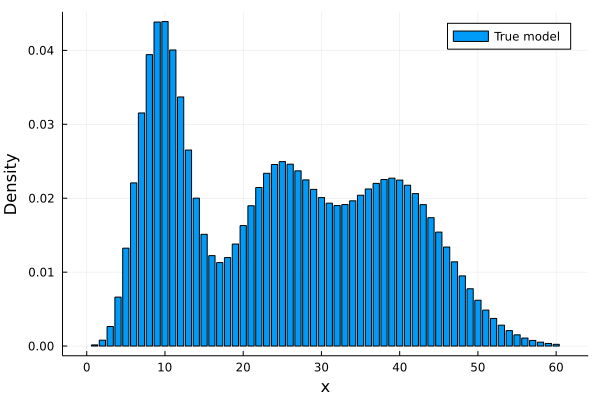

In [6]:
bar(x -> pdf(true_model, x), 1:60, label="True model", xlabel="x", ylabel="Density")

## 観測データを生成

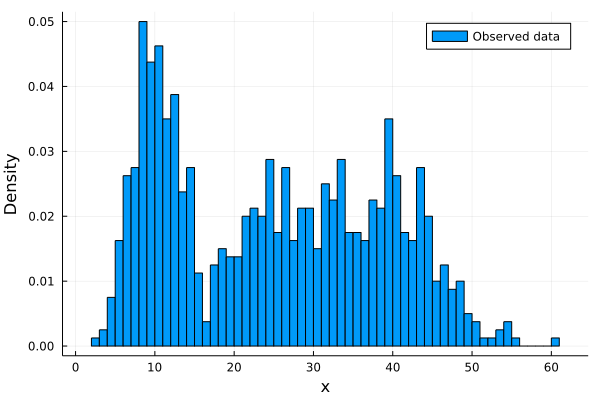

In [7]:
N = 800
mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

data = Float64[]
for (idx, val) in enumerate(λ_true)
    n = count(cluster_num .== idx)
    poi_obs = Poisson(val)
    data = vcat(data, rand(poi_obs, n))
end

bins = 80
histogram(data; bins, label="Observed data", xlabel="x", ylabel="Density", norm=:pdf)

## 変分推論

## 導出

## 実装

In [14]:
N = 800
K = 3
max_iter = 100

â = ones(max_iter+1, K)
b̂ = ones(max_iter+1, K)
α̂ = ones(max_iter+1, K) # \alpha\hat + <TAB>
E_s = rand(K, N)
â[1, :] = sum(E_s .* data', dims=2)
b̂[1, :] = sum(E_s, dims=2)
α̂[1, :] = sum(E_s, dims=2)

λ_sample = zeros(max_iter, K)
π_sample = zeros(max_iter, K)

for i in 1:max_iter
    
    E_λ = â[i, :] ./ b̂[i, :]
    E_lnλ = ψ.(â[i, :]) .- log.(b̂[i, :])
    E_lnπ = ψ.(α̂[i, :]) .- ψ.(sum(α̂[i, :], dims=1))
    
    η_ = exp.(data' .* E_lnλ .- E_λ .+ E_lnπ)
    η = η_ ./ sum(η_, dims=1)
　　
    â[i+1, :] += vec(sum(η .* data', dims=2))
    b̂[i+1, :] += vec(sum(η, dims=2))
    for k in 1:K
        gam = Gamma(â[i+1, k], 1 ./ b̂[i+1, k])
        λ_sample[i, k] = rand(gam)[1]
    end
　　
    α̂[i+1, :] += vec(sum(η, dims=2))
    dir = Dirichlet(α̂[i+1, :])
    π_sample[i, :] = rand(dir)
    
    if i % 10 == 1
        println("iteration: $i")
    end
end

iteration: 1
iteration: 11
iteration: 21
iteration: 31
iteration: 41
iteration: 51
iteration: 61
iteration: 71
iteration: 81
iteration: 91


## サンプルしたパラメータを使って分布を確認

┌ Info: Saved animation to 
│   fn = /Users/akifumiabe/Julia/BayesMLBook/vi_poisson.gif
└ @ Plots /Users/akifumiabe/.julia/packages/Plots/T6yvp/src/animation.jl:114


Plots.AnimatedGif("/Users/akifumiabe/Julia/BayesMLBook/vi_poisson.gif")
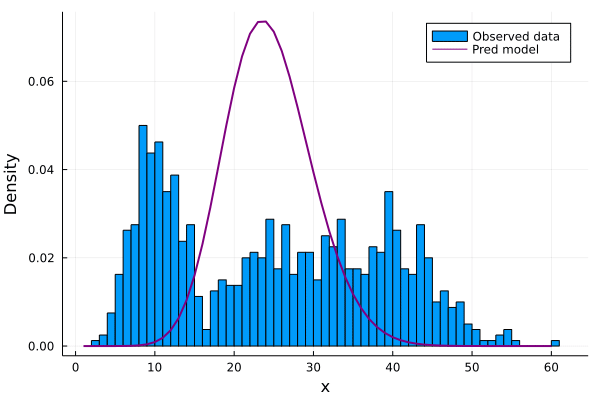

In [15]:
xs = 1:60
anim = @animate for i in 1:max_iter
    p = histogram(data; bins, norm=:pdf, label="Observed data", xlabel="x", ylabel="Density")
    d = MixtureModel([Poisson(λ) for λ in λ_sample[i, :]], π_sample[i, :])
    p = plot!(xs, pdf(d, xs), label="Pred model", linewidth=2, color="purple")
end

gif(anim, "vi_poisson.gif", fps=10)